# Initialization

In [1]:
%matplotlib inline

In [2]:
import os
from pathlib import Path
from tempfile import mkstemp
import shutil
import datetime

import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.rc('figure', figsize=(6, 4.5))
mpl.rcParams['font.size'] = 10
mpl.rcParams['figure.dpi'] = 150
mpl.rcParams['figure.facecolor'] = 'w'
mpl.rcParams['hatch.linewidth'] = 0.5
mpl.rcParams['hatch.color'] = '0.25'

import xarray as xr

from scipy.special import erf
from numpy import pi as π

In [3]:
# trig functions that take degrees

def sind(x):
    return np.sin(np.deg2rad(x))

def cosd(x):
    return np.cos(np.deg2rad(x))

# MOM6 notes

## FMS Namelist entries

### fms_nml

- `clock_grain`:  character,  DEFAULT='NONE'
  - The level of clock granularity used for performance timing sections
     of code. Possible values in order of increasing detail are:
     'NONE', 'COMPONENT', 'SUBCOMPONENT', 'MODULE_DRIVER', 'MODULE', 'ROUTINE',
     'LOOP', and 'INFRA'.  Code sections are defined using routines in MPP
     module: `mpp_clock_id`, `mpp_clock_begin`, and `mpp_clock_end`.
     The fms module makes these routines public.
     A list of timed code sections will be printed to STDOUT.
     See the MPP module for more details.
     
- `clock_flags`: character  DEFAULT='NONE'
  - Possible values are 'NONE', 'SYNC', or 'DETAILED'.
     SYNC will give accurate information on load balance of the clocked
     portion of code.
     DETAILED also turns on detailed message-passing performance diagnosis.
     Both SYNC and DETAILED will  work correctly on innermost clock nest
     and distort outer clocks, and possibly the overall code time.
     See the MPP
     module for more details.
     
- `read_all_pe`: logical  DEFAULT=.TRUE.
  - Read global data on all processors extracting local part needed (TRUE) or
     read global data on PE0 and broadcast to all PEs (FALSE).
     
- `warning_level`: character  DEFAULT='warning'
  - Sets the termination condition for the WARNING flag to interfaces
     error_mesg/mpp_error. set `warning_level = 'fatal'` (program crashes for
     warning messages) or 'warning' (prints warning message and continues).

- `stack_size`: integer  DEFAULT=0
  - The size in words of the MPP user stack. If stack_size > 0, the following
     MPP routine is called: `call mpp_set_stack_size (stack_size)`. If `stack_size
     = 0` (default) then the default size set by mpp_mod is used.
     
- `domains_stack_size`: integer  DEFAULT=0
  - The size in words of the MPP_DOMAINS user stack. If
     `domains_stack_size > 0`, the following MPP_DOMAINS routine is called:
     `call mpp_domains_set_stack_size (domains_stack_size)`. If
     `domains_stack_size = 0` (default) then the default size set by
     mpp_domains_mod is used.

- `print_memory_usage`: logical  DEFAULT=.FALSE.
  - If set to .TRUE., memory usage statistics will be printed at various
     points in the code. It is used to study memory usage, e.g to detect
     memory leaks.


### diag_manager_nml

- `append_pelist_name`: LOGICAL DEFAULT=.FALSE.
- `mix_snapshot_average_fields`: LOGICAL DEFAULT=.FALSE.
  - Set to .TRUE. to allow both time average and instantaneous fields in the same output file.
- `max_files`: INTEGER DEFULT=31
  -  Maximum number of output files allowed.
- `max_output_fields` INTEGER DEFAULT=300
  - Maximum number of output fields.
- `max_input_fields`: INTEGER DEFAULT=300
  - Maximum number of input fields.
- `max_out_per_in_field` INTEGER DEFAULT=150
  - Maximum number of output_fields per input_field.
- `max_axes`: INTEGER DEFAULT=60
  - Maximum number of independent axes.
- `do_diag_field_log`: LOGICAL DEFAULT=.FALSE.
- `write_bytes_in_files`: LOGICAL DEFAULT=.FALSE.
- `flush_nc_files` LOGICAL DEFAULT=.FALSE.
   - Indicate if diag_manager should force the flush of the netCDF diagnostic
     files to disk Note: changing this to .TRUE. can greatly reduce the model
      performance as at each write to the netCDF diagnostic file, the model must
      wait until the flush to disk finishes.
- `debug_diag_manager`: LOGICAL DEFAULT=.FALSE.
- `max_num_axis_sets`: INTEGER DEFAULT=25
- `use_cmor`: LOGICAL DEFAULT=.FALSE.
  - Let the `diag_manager` know if the missing value (if supplied) should be overridden to be the
     CMOR standard value of -1.0e20.
- `issue_oor_warnings`: LOGICAL DEFAULT=.TRUE.
  - If `.TRUE.`, then the `diag_manager` will check for values outside the valid range.  This range is defined in
     the model, and passed to the `diag_manager_mod` via the OPTIONAL variable range in the `register_diag_field`
     function.
- `oor_warnings_fatal`: LOGICAL DEFAULT=.FALSE.
  - If `.TRUE.` then `diag_manager_mod` will issue a `FATAL` error if any values for the output field are
     outside the given range.
- `max_field_attributes`: TYPE=INTEGER DEFAULT=4
  - Maximum number of user definable attributes per field.
- `max_file_attributes`: INTEGER DEFAULT=2
   - Maximum number of user definable global attributes per file.
- `prepend_date`: LOGICAL DEFAULT=.TRUE.
  - If `.TRUE.` then prepend the file start date to the output file.  `.TRUE.` is only supported if the
      diag_manager_init routine is called with the optional time_init parameter.  Note: This was usually done by FRE after the
     model run.
- `region_out_use_alt_value` LOGICAL DEFAULT=.TRUE.
  - Will determine which value to use when checking a regional output if the region is the full axis or a sub-axis.
     The values are defined as `GLO_REG_VAL` (-999) and `GLO_REG_VAL_ALT` (-1) in `diag_data_mod`.
- `use_mpp_io` LOGICAL DEFAULT=.false.
   -  Set to true, diag_manager uses mpp_io.  Default is fms2_io.

# Basic parameters

In [4]:
# suffix = '_faster_sponge'
# suffix = '_newsponge'
# suffix = '_uv_sponge'
suffix = ''
Lx = 8000      # zonal extent
Ly = 3000      # meridional extent

Nl = 2         # number of vertical layers

topog = 'flat'

In [6]:
dx = 5.0 
# dx = 12.5
# dx = 25.0


## Physical paramters

In [7]:
#                 1  2  3  4   5  6   7   8 
def dim_to_nondim(L, U, H1, H, g, gp, f0, β):
    '''
    Convert dimensional constants to nondimensional constants.
    '''    
    F0 = f0**2*L**2/(g*H1)       # inverse Burger number for the free surface
    F1 = f0**2*L**2/(gp*H1)      # inverse Burger number for the upper layer
    F2 = f0**2*L**2/(gp*(H-H1))  # inverse Burger number for the lower layer
    ε = U/(f0*L)                 # Rossby number
    b = β*L/f0                   # beta number
    
    return ε, F0, F1, F2, b


def nondim_to_dim(ε, F0, F1, F2, b, L, f0, gp):
    β = b*f0/L
    H1 = f0**2*L**2/(gp*F1)
    H = H1 + f0**2*L**2/(gp*F2)
    
    if F0 == 0:
        g = np.inf
    else:
        g = f0**2*L**2/(H1*F0)
        
    U = ε*f0*L
    
    return U, H1, H, g, β    

In [8]:
def mean_diff_from_endpoints(L, U, δ, HS, HN, g, f0, β):
    H1 = (HS + HN)/2 # scale for thickness upper layer
    ΔH = (HS - HN)/2 # change in thermocline depth across jet

    # The reduced gravity is constrained by the required velocity and depth change across the thermocline
    gp = 1/(ΔH/(U*L*(f0 - 2*β*L*δ)) - 1/g) # reduced gravity

    return H1, ΔH, gp

def endpoints_from_mean(L, U, δ, H1, g, gp, f0, β):
    gbar = g*gp/(g + gp)
    
    ΔH = L*U*(f0 - 2*L*β*δ)/gbar
    
    HS = H1 + ΔH
    HN = H1 - ΔH
    
    return HS, HN, ΔH

In [9]:
# L = 2*27e3 # basic scale (twice the size for testing)
# U = 2.05/2 # max velocity (half the velocity for testing)
L = 27e3 # basic scale 
U = 2.73 # max velocity 
δ = 0.26 # asymmetry parameter
HS = 792.868 # southern thermocline depth
HN = 192.868 # northern thermocline depth
H = 5000 # maximum ocean depth
θ0 = 35 # central latitude
useBeta = True

smoothing_width = 15e3 # m


# immutable physical parameters
Ω = 7.29e-5 # planetary rotation rate
a = 6378e3  # Earth radius
g = 9.8 # gravitational acceleration
rho0 = 1035 # Boussinesq reference density
km2m = 1000
    
# derived quantities
f0 = 2*Ω*sind(θ0) # Coriolis parameter
if useBeta:
    β = 2*Ω*cosd(θ0)/a # beta
else:
    β = 0
print('f0 = {:.3g}, β = {:.3g}'.format(f0, β))
    
H1 = (HS + HN)/2 # scale for thickness upper layer
ΔH = (HS - HN)/2 # change in thermocline depth across jet

# The reduced gravity is constrained by he required velocity and depth change across the thermocline
gp = 1/(ΔH/(U*L*(f0 - 2*β*L*δ)) - 1/g) # reduced gravity

print('H1 = {:.1f},  gp = {:.3g}'.format(H1, gp))

# nondimensional parameters
ε, F0, F1, F2, b = dim_to_nondim(L, U, H1, H, g, gp, f0, β)

print('F0 = {:.2g}, F1 = {:.3f}, F2 = {:.2g}'.format(F0, F1, F2))
print('ε = {:.2f}, b = {:.2g}'.format(ε, b))

f0 = 8.36e-05, β = 1.87e-11
H1 = 492.9,  gp = 0.0205
F0 = 0.0011, F1 = 0.504, F2 = 0.055
ε = 1.21, b = 0.006


# Timestep

We pick a timestep that evenly divides a day, is larger than a given value, and produces a CFL less than a maximum value.

In [10]:
target_min = 400
max_cfl = .25

p2, p3, p5 = np.meshgrid(np.arange(8), np.arange(4), np.arange(3))
deltas = np.unique((2**p2 * 3**p3 * 5**p5).flatten())

cfl = U*deltas/(dx*km2m)
deltas = deltas[(deltas >= target_min) & (cfl <= max_cfl)]
deltas

array([400, 432, 450])

In [11]:
2*360*277.391973/30/3600

1.84927982

In [12]:
Δt = 540
# Δt = 600
# Δt = 3600

# Grid

## Horizontal

In [35]:
11520.000/360

32.0

In [13]:
y0 = 0

xw = 0
xe = xw + Lx
ys = -Ly/2
yn =  Ly/2

xq = np.arange(xw, xe+dx, dx)
xh = np.arange(xw+dx/2, xe, dx)

yq = np.arange(ys, yn+dx, dx)
yh = np.arange(ys+dx/2, yn, dx)

NX = len(xh)
NY = len(yh)

grid = xr.Dataset({}, coords={
    'xq': (['xq'], xq),
    'xh': (['xh'], xh),
    'yq': (['yq'], yq),
    'yh': (['yh'], yh),
})
grid

<xarray.Dataset>
Dimensions:  (xq: 1601, xh: 1600, yq: 601, yh: 600)
Coordinates:
  * xq       (xq) float64 0.0 5.0 10.0 15.0 ... 7.99e+03 7.995e+03 8e+03
  * xh       (xh) float64 2.5 7.5 12.5 17.5 ... 7.988e+03 7.992e+03 7.998e+03
  * yq       (yq) float64 -1.5e+03 -1.495e+03 -1.49e+03 ... 1.495e+03 1.5e+03
  * yh       (yh) float64 -1.498e+03 -1.492e+03 ... 1.492e+03 1.498e+03
Data variables:
    *empty*

## Vertical

In [14]:
delta_rho = rho0*gp/g
zl = rho0 + np.array([0, delta_rho])
zi = rho0 + np.array([0, delta_rho, delta_rho]) - delta_rho/2

grid.coords['zl'] = (['zl'], zl)
grid.coords['zi'] = (['zi'], zi)
grid

<xarray.Dataset>
Dimensions:  (xq: 1601, xh: 1600, yq: 601, yh: 600, zl: 2, zi: 3)
Coordinates:
  * xq       (xq) float64 0.0 5.0 10.0 15.0 ... 7.99e+03 7.995e+03 8e+03
  * xh       (xh) float64 2.5 7.5 12.5 17.5 ... 7.988e+03 7.992e+03 7.998e+03
  * yq       (yq) float64 -1.5e+03 -1.495e+03 -1.49e+03 ... 1.495e+03 1.5e+03
  * yh       (yh) float64 -1.498e+03 -1.492e+03 ... 1.492e+03 1.498e+03
  * zl       (zl) float64 1.035e+03 1.037e+03
  * zi       (zi) float64 1.034e+03 1.036e+03 1.036e+03
Data variables:
    *empty*

# Make input directory

In [16]:
expname = 'F{:.3f}-{:.2f}-{:.2f}_Ro{:.2f}_b{:.3f}{:s}'.format(F0, F1, F2, ε, b, suffix)
target = os.path.join('..','{:d}layer'.format(Nl), topog, '{:g}km_dt{:04d}'.format(dx, int(Δt), suffix), expname)

Path(os.path.join(target, 'INPUT')).mkdir(exist_ok=True, parents=True)

print(target)

jet_ic = xr.Dataset()

../2layer/flat/5km_dt0540/F0.001-0.50-0.06_Ro1.21_b0.006


## Fix up the override file

In [17]:
file_path = os.path.join(target, 'MOM_override')

fh, abs_path = mkstemp()

with os.fdopen(fh, 'w') as new_file:
    with open(file_path, 'r') as old_file:
        for line in old_file:
            if 'gint' in line.lower():
                new_file.write('#override GINT = {:.17g}'.format(gp)
                               + '    ! written by gendata.ipynb on ' + str(datetime.date.today()) + '\n')
            else:
                new_file.write(line)
            
# copy permissions
shutil.copymode(file_path, abs_path)
# remove original file
os.remove(file_path)
# move over new file
shutil.move(abs_path, file_path)

'../2layer/flat/5km_dt0540/F0.001-0.50-0.06_Ro1.21_b0.006/MOM_override'

In [18]:
540*3

1620

# Sponges

We use a combination of velocity relaxation and viscosity to simulate "open" boundaries. Velocity relaxation has the advantage that it will give you exactly the velocity profile you want, but this can be a disadvantage if you don't know what the velocity should be. Viscosity has no effect on inform flow (for free slip boundaries), so can be used to gently push the velocity toward uniform flow.

The basic structure is a region of width `sponge_width` where the relaxation rate is constant and maximum matched to a linear ramp down to zero of width `sponge_ramp`. The sponges may well need to be wider.

## Viscous

The CFL number for harmonic viscosity is

$$
    S_{2} = \frac{K_h \Delta t}{4\Delta x^2}.
$$

We pick $S_2 = 0.15$ and set the maximum viscosity based on that.

In [19]:
S2 = .15 # viscous CFL number
Δx = dx*km2m # grid spacing in meters
Kh_max = S2*Δx**2/(4*Δt)
Kh_max

1736.111111111111

Similarly, the CFL number for biharmonic viscosity is

$$
    S_{4} = \frac{K_4 \Delta t}{16\Delta x^4}.
$$

Biharmonic viscosity is more scale selective than harmonic, which is not what we actually want for the sponges.

In [20]:
K4 = 5.140776e8
K4*Δt/(16*Δx**4)

2.77601904e-05

In [21]:
sponge_ramp = 200
sponge_widthy = 200 # in km
Kh_S = Kh_max*np.minimum(np.maximum((sponge_ramp - (grid.yh - ys - sponge_widthy))/sponge_ramp, 0), 1)
Kh_N = Kh_max*np.minimum(np.maximum((sponge_ramp + (grid.yh - yn + sponge_widthy))/sponge_ramp, 0), 1)

Kh_NS = np.maximum(Kh_S, Kh_N) + 0*grid.xh

sponge_rampW = 200
sponge_widthW = 0
sponge_rampE = 200
sponge_widthE = 1600

Kh_W = Kh_max*np.minimum(np.maximum((sponge_rampW - (grid.xh - xw - sponge_widthW))/sponge_rampW, 0), 1)
Kh_E = Kh_max*np.minimum(np.maximum((sponge_rampE + (grid.xh - xe + sponge_widthE))/sponge_rampE, 0), 1)

Kh_EW = grid.yh*0 + np.maximum(Kh_W, Kh_E)

jet_ic['Kh'] = np.maximum(Kh_EW, Kh_NS)

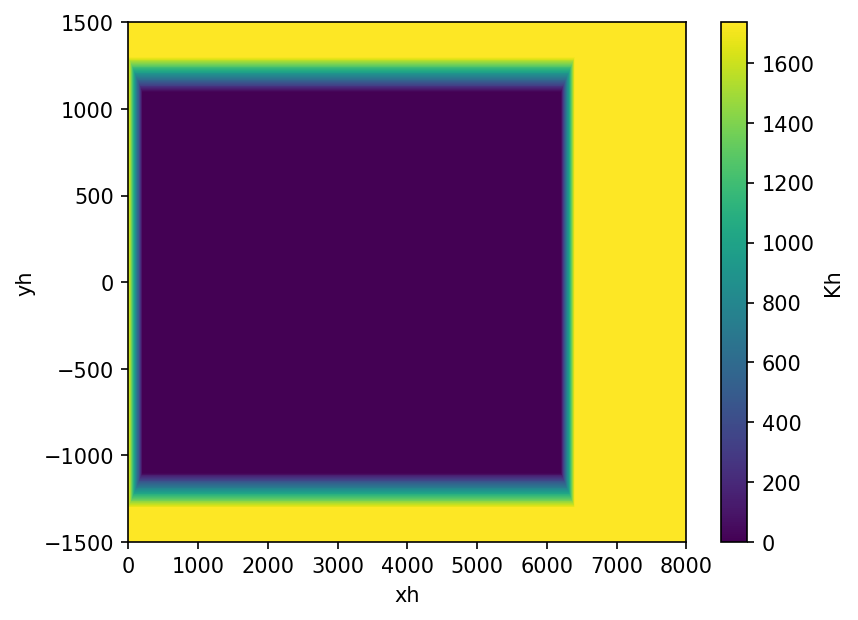

In [22]:
jet_ic.Kh.plot()

## Velocity relaxation

In [23]:
peak_damping = 1

sponge_rampW = 200
sponge_widthW = 400
sponge_rampE = 200
sponge_widthE = 0

### Zonal velocity

In [24]:
damp_W = peak_damping*np.minimum(np.maximum((sponge_rampW - (grid.xq - xw - sponge_widthW))/sponge_rampW, 0), 1)
damp_E = peak_damping*np.minimum(np.maximum((sponge_rampE + (grid.xq - xe + sponge_widthE))/sponge_rampE, 0), 1)

damp_EW = 0*grid.yh + np.maximum(damp_W, damp_E)

jet_ic['Idamp_u'] = damp_EW/3600/24

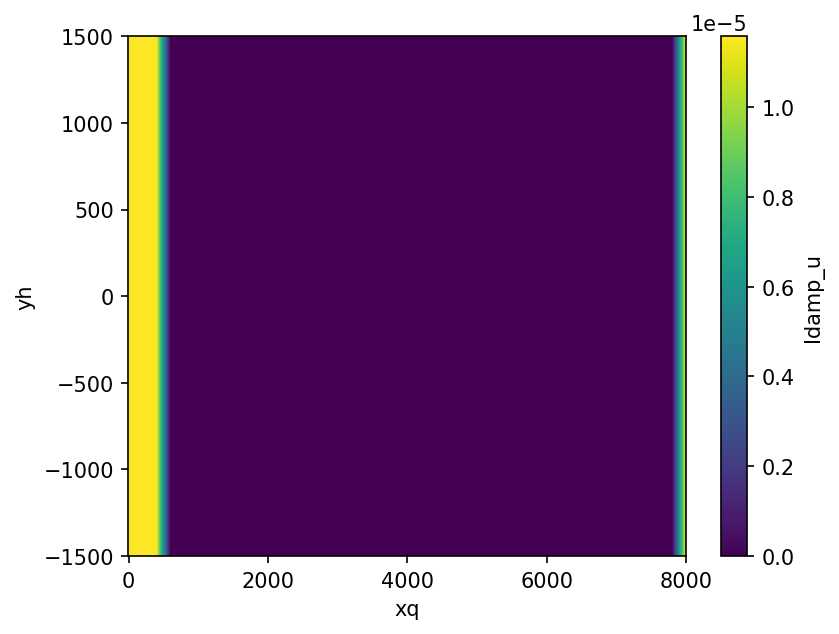

In [25]:
jet_ic.Idamp_u.plot()

### Meridional velocity

In [26]:
damp_W = peak_damping*np.minimum(np.maximum((sponge_rampW - (grid.xh - xw - sponge_widthW))/sponge_rampW, 0), 1)
damp_E = peak_damping*np.minimum(np.maximum((sponge_rampE + (grid.xh - xe + sponge_widthE))/sponge_rampE, 0), 1)

damp_EW = 0*grid.yq + np.maximum(damp_W, damp_E)

jet_ic['Idamp_v'] = damp_EW/3600/24

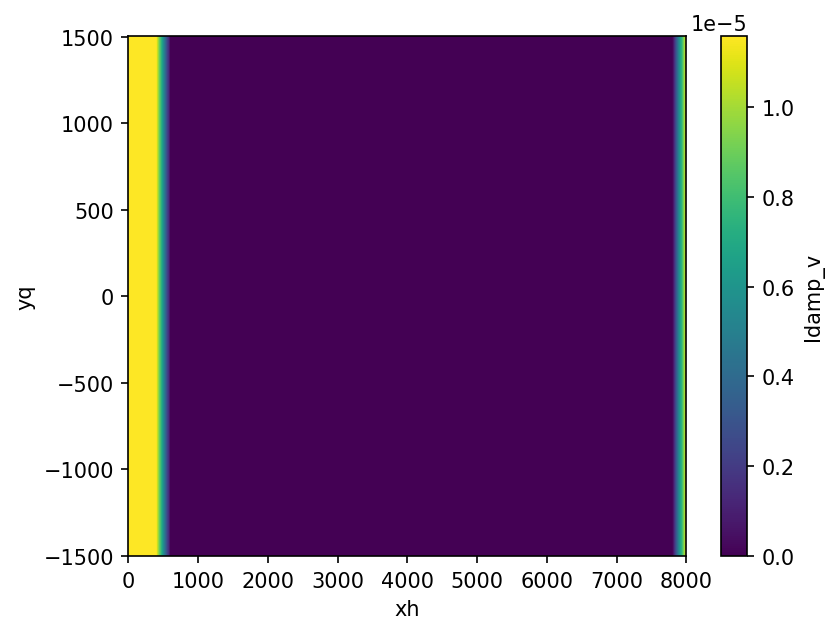

In [27]:
jet_ic.Idamp_v.plot()

# Target and initial heights and velocity

## Smoothed front

We probably want Neumann condition on one end to avoid small curvature at the ends due to the fact that we're on a finite domain.

The inversion problem is 

$$
    \bar{g}\left(\frac{h_y}{f}\right)_y - \tilde{q} h = -f,
$$

where 

$$
\begin{aligned}
    \bar{g} &= \frac{g g'}{g + g'}, \\
    \tilde{q} &= \frac{1}{\sqrt{\pi}d}\int q(y-y') \, e^{-y'^2/d^2}\, d y', \\
    q &= \frac{f - u_y}{h}, \\
    u &= \begin{cases}
            e^{y/L(1+\delta)}  & y \le 0, \\
            e^{-y/L(1-\delta)} & y > 0,
        \end{cases},\\
    h &= H_1 + \left(1 + \frac{g}{g'}\right)\eta_0, = H_1 + \frac{L U}{\bar{g}} \begin{cases}
        \phantom{-}f_0 - 2 \beta L \delta - (1+\delta)\left[f - \beta L (1+\delta)\right]e^{y/L(1+\delta)} & y \le 0, \\
        -f_0 + 2 \beta L \delta + (1-\delta)\left[f + \beta L (1-\delta)\right]e^{-y/L(1-\delta)} & y \le 0,
    \end{cases}\\
    \eta_0 &= \frac{L U}{g}\begin{cases}
        \phantom{-}f_0 - 2\beta L\delta - (1+\delta)*\left[f - \beta L(1+\delta)\right]e^{y/(L(1+\delta))} & y \le 0, \\
        -f_0 + 2\beta L\delta + (1-\delta)*\left[f + \beta L(1-\delta)\right]e^{-y/(L(1-\delta))} & y > 0.
    \end{cases}
\end{aligned}
$$

In [28]:
def unsmoothed_front(Ly, dy, L, δ, U, H1, g, gp, f0, β):
    
    ys = -Ly/2
    yn =  Ly/2

    yh = np.arange(ys+dy/2, yn, dy)
    fh = f0 + β*yh
    
    η1 = -H1 - L*U/gp*np.where(yh <= 0, 
                   +f0 - 2*β*L*δ - (1+δ)*(fh - β*L*(1+δ))*np.exp(+yh/(L*(1+δ))),
                   -f0 + 2*β*L*δ + (1-δ)*(fh + β*L*(1-δ))*np.exp(-yh/(L*(1-δ))),
                   )
    
    η0 = -(η1 + H1)*gp/g
    
    h1 = η0 - η1

    u1 = U*np.where(yh <= 0, 
                    np.exp( yh/(L*(1+δ))),
                    np.exp(-yh/(L*(1-δ))),
                   )
    
    ζ1 = -(U/L)*np.where(yh <= 0, 
                     np.exp( yh/(L*(1+δ)))/(1+δ),
                    -np.exp(-yh/(L*(1-δ)))/(1-δ),
                   )

    q1 = (fh + ζ1)/h1

    return yh, η0, η1, u1, q1


In [29]:
def smoothed_front_PV(Ly, dy, L, δ, U, H1, g, gp, f0, β, d, return_all=False):
    _, _, _, _, q = unsmoothed_front(Ly, dy, L, δ, U, H1, g, gp, f0, β)

    # some dimensional constants
    gbar = g*gp/(g + gp)
    
    # some nondimensional constants
    b = β*L/f0
    ε = U/(f0*L)
    F = f0**2*L**2/(gbar*H1)
    
    ys = -Ly/2
    yn =  Ly/2

    yh = np.arange(ys+dy/2, yn, dy)
    fh = f0 + β*yh

    NY = len(yh)
    
    # The jump produces poor convergence for the numerical convolution, 
    # so we first calculate the jump and remove it. All this song and dance doesn't seem
    # to improve the order of convergence, but it does reduce the error by about an order of magnitude.
    # This could be improved by a direct implementation of the convolution integral.
    C1 = (1 - ε/(1+δ))/(1 + ε*F*( 1 - 2*b*δ - (1+δ)*(1 - b*(1+δ))))
    C2 = b/L/(1+ε*F*(1 - 2*b*δ))
    C3 = (1 + ε/(1-δ))/(1 + ε*F*(-1 + 2*b*δ + (1-δ)*(1 + b*(1-δ))))
    C4 = b/L/(1-ε*F*(1 - 2*b*δ))
    
    qj = (f0/H1)*np.where(yh<=0, C1 + C2*yh, C3 + C4*yh)
    qp = q - qj
    
    # We then only smooth qp
    if d == 0:
        hflt = np.array([1])
    else:
        hflt = np.exp(-yh**2/d**2)        
        hflt /= hflt.sum()
    
    yS = dy*np.arange(-NY,  0) + yh[ 0]
    yN = dy*np.arange(1, NY+1) + yh[-1]
    
    # pad so the convolution doesn't introduce edge effects
    qtmp = np.zeros(3*NY)
    qtmp[:NY] = qp[0]
    qtmp[NY:2*NY] = qp
    qtmp[2*NY:] = qp[-1]
    qps = np.convolve(hflt, qtmp, mode='same')[NY:2*NY]

    # add back on the analyically smoothed jump
    qjs = 0.5*(f0/H1)*(C1 + C3 + (C2 + C4)*yh + d*(C4-C2)*np.exp(-yh**2/d**2)/np.sqrt(π) + (C3 - C1 + yh*(C4-C2))*erf(yh/d))
    qs = qjs + qps
    
    if return_all:
        return yh, qs, q, qj, qjs, qp, qps
    else:
        return qs

The numerical problem is

$$
    -\frac{h_{j-1}}{f_{j-1/2}} + \left(\frac{1}{f_{j-1/2}} + \frac{1}{f_{j+1/2}} + \frac{\Delta y^2}{\bar{g}}q_j\right)
        -\frac{h_{j+1}}{f_{j+1/2}} = \frac{\Delta y^2}{\bar{g}}f_j
$$

The far field boundary conditions are

$$
    h = H_s + \frac{\sqrt{\bar{g}H_s}}{f}h_y
$$

in the south and

$$
    h = H_n - \frac{\sqrt{\bar{g}H_n}}{f}h_y
$$

in the north.

If these are discretized using 2nd order centered differences, they become

$$
    \frac{\sqrt{\bar{g}H_s}}{2\Delta y f_0}\left(h_1 - h_{-1}\right) - h_0 = -H_s,
$$

and

$$
    \frac{\sqrt{\bar{g}H_n}}{2\Delta y f_{J-1}}\left(h_{J} - h_{J-2}\right) + h_{J-1} = H_n,
$$

Substituting these into the $j = 0$ and $j = J-1$ equations gives

$$
    \left(\frac{1 + 2\Delta y f_0/\sqrt{\bar{g}H_s}}{f_{-1/2}} + \frac{1}{f_{1/2}} + \frac{\Delta y^2}{\bar{g}}q_0\right)
        -\left(\frac{1}{f_{-1/2}} + \frac{1}{f_{1/2}}\right)h_{1} = \frac{\Delta y^2}{\bar{g}}f_0 + 2\Delta y \sqrt{\frac{H_s}{\bar{g}}}\frac{f_0}{f_{-1/2}}
$$

and

$$
     -\left(\frac{1}{f_{J-3/2}} + \frac{1}{f_{J-1/2}}\right)h_{J-2}  \left(\frac{1}{f_{J-3/2}} 
         + \frac{1 + 2\Delta y f_{J-1}/\sqrt{\bar{g}H_n}}{f_{J-1/2}} + \frac{\Delta y^2}{\bar{g}}q_{J-1}\right)
       = \frac{\Delta y^2}{\bar{g}}f_{J-1} + 2\Delta y \sqrt{\frac{H_n}{\bar{g}}}\frac{f_{J-1}}{f_{J-1/2}}
$$


It turns out that using second order differences ruins the symmetry of the problem. If we instead use first order differences, so

$$
    \frac{\sqrt{\bar{g}H_s}}{f_{1/2}}\frac{h_1 - h_0}{\Delta y} - h_0 = -H_s
$$

and 

$$
    \frac{\sqrt{\bar{g}H_n}}{f_{J-3/2}}\frac{h_{J-1} - h_{J-2}}{\Delta y} + h_{J-1} = H_n
$$

then we can simply replace the first and last equation with these boundary conditions multiplied by $\Delta y/\sqrt{\bar{g}H_s}$ and $\Delta y/\sqrt{\bar{g}H_n}$, respectively, and we still end up with a symmetric tri-diagonal matrix.

In [30]:
def smoothed_front(Ly, dy, L, δ, U, HS, HN, g, gp, f0, β, d):
    '''
    Smooth a pv distribution and compute u and h from that smoothed distribution.
    
    All inputs should be in MKS
    
        
    returns
    -------
    y : ndarray
        Grid
    q : ndarray
        smoothed PV
    h : ndarray
        Thickness
    u : ndarray
        Velocity
    '''
    from scipy.linalg import solveh_banded
    
    ys = -Ly/2
    yn =  Ly/2

    yq = np.arange(ys, yn+dy, dy)
    yh = np.arange(ys+dy/2, yn, dy)

    NY = len(yh)
    
    H1 = (HS + HN)/2
    qs = smoothed_front_PV(
        Ly = Ly,
        dy = dy,
        L = L,
        δ = δ,
        U = U,
        H1 = H1,
        g = g,
        gp = gp,
        f0 = f0,
        β = β,
        d = d
    )
    
    fh = f0 + β*yh
    fq = f0 + β*yq
    
    gbar = g*gp/(g + gp) # harmonic mean of gravity and reduced gravity
        
    # The matrix ab is stored in the "lower" form where the first row is the main diagonal 
    # and the second row is the lower diagonal
    ab = np.zeros((2, NY))
    ab[0,:] = 1/fq[1:] + 1/fq[:-1] + dy**2*qs/gbar
    ab[1,:] = -1/fq[1:]

    rhs = fh*dy**2/gbar
    
    # Modify the first and last rows to fit the boundary conditions
    # ab[0,0] = (1 + 2*dy*fh[0]/np.sqrt(gbar*HS))/fq[0] + 1/fq[1] + dy**2*qs[0]/gbar
    # ab[1,0] = -1/fq[1] - 1/fq[0]    
    # rhs[ 0] += 2*dy*np.sqrt(HS/gbar)*fh[0]/fq[0]
    
    # replece the first and last equations with the boundary conditions
    ab[0,0] = 1/fq[1] + dy/np.sqrt(gbar*HS)
    rhs[0]  = dy*np.sqrt(HS/gbar)
    # rhs[ 0] += HS/fq[0]
    
    # ab[0,-1] = (1 + 2*dy*fh[-1]/np.sqrt(gbar*HN))/fq[-1] + 1/fq[-2] + dy**2*qs[-1]/gbar
    # ab[1,-2] = -1/fq[-2] - 1/fq[-1]
    # rhs[-1] += 2*dy*np.sqrt(HN/gbar)*fh[-1]/fq[-1]
    ab[0,-1] = 1/fq[-2] + dy/np.sqrt(gbar*HN)
    rhs[-1] = dy*np.sqrt(HN/gbar)
    # rhs[-1] += HN/fq[-1]
    
    # return ab, rhs

    h = solveh_banded(ab, rhs, overwrite_ab=True, overwrite_b=True, lower=True)
    u = np.zeros(NY)
    # Use the far-field solution for the boundary condition of u
    # u[0]    = -gbar*(h[1] - HS)/(2*dy)/fh[0]
    # u[-1]   = -gbar*(HN - h[-2])/(2*dy)/fh[-1]
    u[0]    = -np.sqrt(gbar/HS)*(h[0] - HS)
    u[1:-1] = -gbar*(h[2:] - h[:-2])/(2*dy)/fh[1:-1]
    u[-1]   = -np.sqrt(gbar/HN)*(HN - h[-1])

    return yh, qs, h, u



In [31]:
# for greatest happiness, solve on a finer grid and subsample to get the final result.

yh_h, q1_h, h1_h, u1_h = smoothed_front(Ly=Ly*km2m, dy=dx*km2m/5, L=L, δ=δ, U=U, HS=HS, HN=HN, g=g, gp=gp, f0=f0, β=β, d=smoothing_width)

q1 = q1_h[2::5]
h1 = h1_h[2::5]
u1 = u1_h[2::5]

η0 = gp*h1/(g + gp)
η1 = -g*h1/(g + gp)

(-125.0, 125.0)

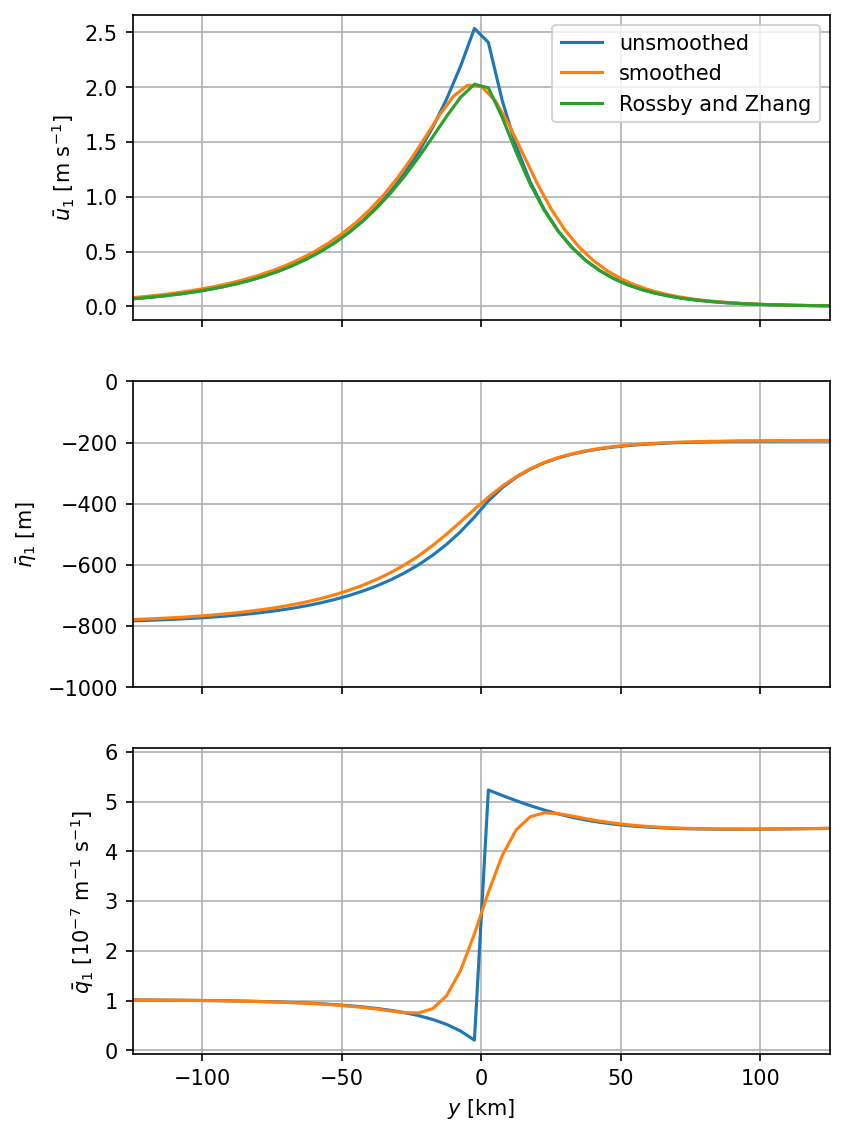

In [32]:
fig, axs = plt.subplots(nrows=3, sharex=True, figsize=(6,9))

y0 = float(grid.yh[np.argmax(u1)])

_, _, η1_un, u1_un, q1_un = unsmoothed_front(Ly*km2m, dx*km2m, L, δ, U, H1, g, gp, f0, β)

σ = 0.25

y = grid.yh.values*km2m
u_r = np.piecewise(y, [y <= 0, y>0], [
    lambda y: U*(np.exp( y/(L*(1+δ))) - σ*np.exp( y/(σ*L*(1+δ)))),
    lambda y: U*(np.exp(-y/(L*(1-δ))) - σ*np.exp(-y/(σ*L*(1-δ))))
])

ax = axs[0]
ax.plot(grid.yh, u1_un, label='unsmoothed')
# ax.plot(grid.yh-y0/3, u1, label='smoothed (shifted by {:.1f} km)'.format(np.abs(y0/3)))
ax.plot(grid.yh-y0/3, u1, label='smoothed')
ax.plot(grid.yh, u_r, label='Rossby and Zhang')
ax.legend()
ax.grid()
ax.set_ylabel(r'$\bar{u}_1$ [m s$^{-1}$]')

ax = axs[1]
ax.plot(grid.yh, η1_un)
ax.plot(grid.yh, η1)
ax.grid()
ax.set_ylabel(r'$\bar{\eta}_1$ [m]')
ax.set_ylim(-1000, 0)

ax = axs[2]
ax.plot(grid.yh, 1e7*q1_un)
ax.plot(grid.yh, 1e7*q1)
ax.grid()
ax.set_ylabel(r'$\bar{q}_1$ [$10^{-7}$ m$^{-1}$ s$^{-1}$]')
ax.set_xlabel('$y$ [km]')
ax.set_xlim(-125, 125)


# Write out

In [33]:
u1_da = xr.DataArray(
    data=u1,
    dims=['yh'],
    coords=dict(
        yh=grid.yh
    )
)

u2_da = 0*grid.yh

v1_da = 0*grid.yq
v2_da = 0*grid.yq

η0_da = xr.DataArray(
    data=η0,
    dims=['yh'],
    coords=dict(
        yh=grid.yh
    )
)

η1_da = xr.DataArray(
    data=η1,
    dims=['yh'],
    coords=dict(
        yh=grid.yh
    )
)

η2_da = -H + 0*grid.yh

try:
    jet_ic = jet_ic.drop(('zi', 'zl'))
except:
    pass

jet_ic[ 'u' ] = xr.concat((u1_da, u2_da           ), 'zl') + 0*grid.xq
jet_ic[ 'v' ] = xr.concat((v1_da, v2_da           ), 'zl') + 0*grid.xh
jet_ic['eta'] = xr.concat([η0_da, η1_da, η2_da], dim='zi') + 0*grid.xh

jet_ic.coords['zl'] = zl
jet_ic.coords['zi'] = zi
jet_ic

<xarray.Dataset>
Dimensions:  (yh: 600, xh: 1600, xq: 1601, yq: 601, zl: 2, zi: 3)
Coordinates:
  * yh       (yh) float64 -1.498e+03 -1.492e+03 ... 1.492e+03 1.498e+03
  * xh       (xh) float64 2.5 7.5 12.5 17.5 ... 7.988e+03 7.992e+03 7.998e+03
  * xq       (xq) float64 0.0 5.0 10.0 15.0 ... 7.99e+03 7.995e+03 8e+03
  * yq       (yq) float64 -1.5e+03 -1.495e+03 -1.49e+03 ... 1.495e+03 1.5e+03
  * zl       (zl) float64 1.035e+03 1.037e+03
  * zi       (zi) float64 1.034e+03 1.036e+03 1.036e+03
Data variables:
    Kh       (yh, xh) float64 1.736e+03 1.736e+03 ... 1.736e+03 1.736e+03
    Idamp_u  (yh, xq) float64 1.157e-05 1.157e-05 ... 1.128e-05 1.157e-05
    Idamp_v  (yq, xh) float64 1.157e-05 1.157e-05 ... 1.114e-05 1.143e-05
    u        (zl, yh, xq) float64 1.068e-12 1.068e-12 1.068e-12 ... 0.0 0.0 0.0
    v        (zl, yq, xh) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    eta      (zi, yh, xh) float64 1.657 1.657 1.657 ... -5e+03 -5e+03 -5e+03

In [34]:
jet_ic.to_netcdf(os.path.join(target, 'INPUT', 'jet_ic.nc'))